# Notebook 3 : interprétabilité du modèle
---

In [24]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from eli5.sklearn.permutation_importance import PermutationImportance
from treeinterpreter import treeinterpreter

import src.config.column_names as col
import src.config.base as base
from src.infrastructure.build_dataset import DataBuilderFactory, DataMerger
from src.domain.cleaning import MissingValueTreatment
from src.domain.build_features import feature_engineering_transformer
from interpretability_utilities import plot_features_importance

In [10]:
from warnings import simplefilter
from pandas.core.common import SettingWithCopyWarning

# Ignorer les warnings pour améliorer la lisibilité
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action="ignore", category=SettingWithCopyWarning)

# 1. Chargement des données

In [3]:
# Build datasets

client_builder = DataBuilderFactory(base.TRAIN_CLIENT_DATA_PATH, base.config_client_data, base.ALL_CLIENT_DATA_TRANSLATION)
client_data = client_builder.transform('client')

eco_builder = DataBuilderFactory(base.TRAIN_ECO_DATA_PATH, base.config_eco_data)
eco_data = eco_builder.transform('eco')

# Merging files to final dataset
X, y = DataMerger(client_data, eco_data, col.MERGER_FIELD).transform()
y = y.eq('Yes').astype(int)

========== Processing client data ==========
- Casting types.
- Translating French terms to English.
- Dropping rows with too many missing values.
- Correcting erroneous entries.
========== Processing eco data ==========
- Casting types.
- Translating French terms to English.
- Dropping rows with too many missing values.
- Imputing missing data.
========== Merging datasets ==========
========== Separating target from explanatory variables ==========


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=base.SEED)

In [5]:
column_names = ['BALANCE', 'NB_CONTACT_CURRENT_CAMPAIGN', 'NB_CONTACT_LAST_CAMPAIGN', 'EDUCATION??', 'EDUCATION_SECONDARY', 
                'HAS_HOUSING_LOAN', 'HAS_PERSO_LOAN', 'HAS_DEFAULT', 'IS_RETIRED', 'WAS_LAST_CAMPAIGN_SUCCESS', 'IS_SINGLE',
               'SUP_25_YEARS_OLD', 'SUP_60_YEARS_OLD', 'AGE', 'LAST_CONTACT_DATE', 'HAS_LOAN', 'IDX_EMPLOYMENT_RATE',
                'IDX_CONSUMER_PRICE', 'IDX_CONSUMER_CONFIDENCE']

# 2. Chargement du modèle et entraînement

In [6]:
pipeline = pickle.load(open(base.SAVED_MODEL_PATH, "rb"))

In [7]:
# Extraction du classifieur
clf = pipeline.best_estimator_.named_steps['rf_clf']

In [8]:
# Extraction des étapes de pre-processing (imputation et feature engineering)
transfo_pipeline = pipeline.best_estimator_[:2]

In [9]:
X_train_transformed = transfo_pipeline.fit_transform(X_train, y_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=column_names, index= X_train.index)

/Users/jeremie/Library/Caches/pypoetry/virtualenvs/productsubscription-oc-jk-rf8_RRH8-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/jeremie/Library/Caches/pypoetry/virtualenvs/productsubscription-oc-jk-rf8_RRH8-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/jeremie/Library

In [13]:
X_test_transformed = transfo_pipeline.fit_transform(X_test, y_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=column_names, index= X_test.index)

In [14]:
print(f'Il y a {X_train_transformed.shape[1]} variables après le feature engineering.\n')
print('Les variables sont les suivantes :')
print(column_names)

Il y a 19 variables après le feature engineering.

Les variables sont les suivantes :
['BALANCE', 'NB_CONTACT_CURRENT_CAMPAIGN', 'NB_CONTACT_LAST_CAMPAIGN', 'EDUCATION??', 'EDUCATION_SECONDARY', 'HAS_HOUSING_LOAN', 'HAS_PERSO_LOAN', 'HAS_DEFAULT', 'IS_RETIRED', 'WAS_LAST_CAMPAIGN_SUCCESS', 'IS_SINGLE', 'SUP_25_YEARS_OLD', 'SUP_60_YEARS_OLD', 'AGE', 'LAST_CONTACT_DATE', 'HAS_LOAN', 'IDX_EMPLOYMENT_RATE', 'IDX_CONSUMER_PRICE', 'IDX_CONSUMER_CONFIDENCE']


# 3. Importance des variables

## a. MDI (Mean Decrease Impurity Importance)

In [15]:
importances = clf.feature_importances_

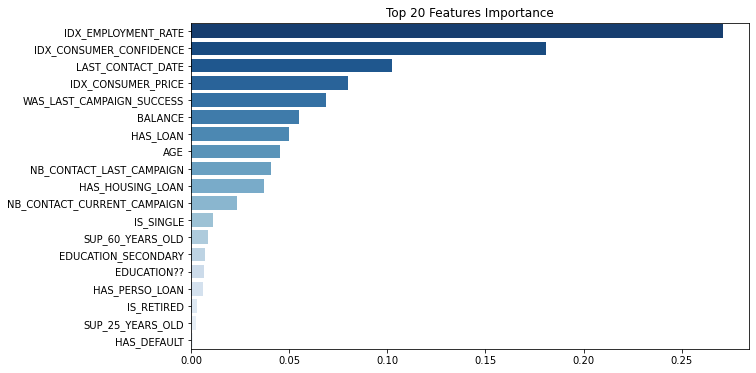

In [16]:
plot_features_importance(X_train_transformed,importances, 20)

## b. Permutation importance

In [19]:
permutation_imp = PermutationImportance(clf, scoring='average_precision', n_iter=20, random_state=42, cv='prefit', refit=False)

In [20]:
permutation_imp.fit(X_test_transformed, y_test)

PermutationImportance(estimator=RandomForestClassifier(class_weight={0: 1,
                                                                     1: 9},
                                                       max_depth=10,
                                                       min_samples_leaf=10,
                                                       n_estimators=220),
                      n_iter=20, random_state=42, refit=False,
                      scoring='average_precision')

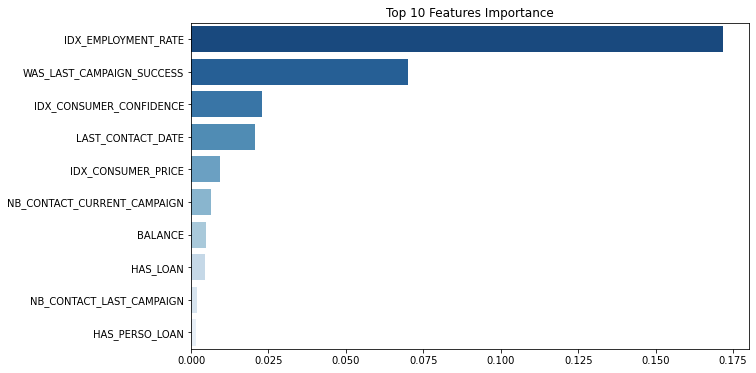

In [22]:
plot_features_importance(data=X_test_transformed, importances=permutation_imp.feature_importances_, n_feat=10)

# 4. Tree interpreter

## a. Contributions globales

In [26]:
predictions, bias, contributions = treeinterpreter.predict(clf, X_test_transformed)

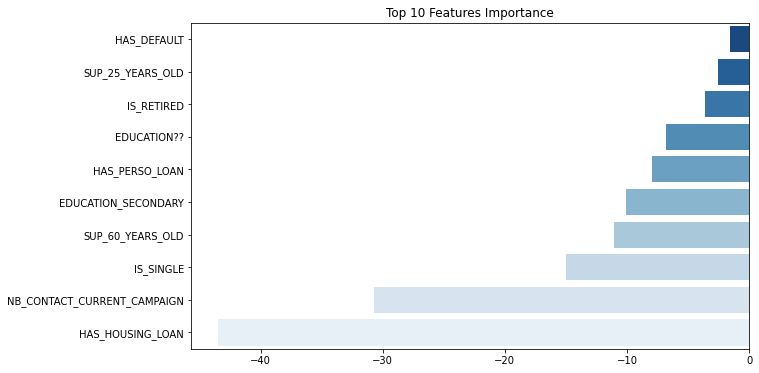

In [30]:
tree_interpreter_importances = contributions[:, :, 1].sum(axis=0)
plot_features_importance(data=X_test_transformed, importances=tree_interpreter_importances, n_feat=10)

## b. Contributions locales